In [104]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
cmap = 'bwr'

from PIL import Image

# for step 0
import os
import re

# for step 1
from collections import defaultdict

# for step 2
from scipy.signal import savgol_filter

import math

## load data

In [105]:
# -------------------------------------------------------------------------
# Step 0: Display the data labels
# -------------------------------------------------------------------------

data_dir = './data/'
folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f)) and f.startswith('G5_res_')]

bin_sizes = set()
collimations = set()
collection_times = set()

for folder in folders:
    parts = folder.split('_')
    if len(parts) >= 4:
        x = parts[2]  # bin size
        y = parts[3].removesuffix('C')  # collimation
        bin_sizes.add(x)
        collimations.add(y)

        folder_path = os.path.join(data_dir, folder)
        for fname in os.listdir(folder_path):
            match = re.match(r'^\d+_d(\d+)_c(\d+)\.dat$', fname)
            if match:
                z1, z2 = match.group(1), match.group(2)
                if z1 == z2:
                    # Strip leading zeros
                    collection_times.add(z1.lstrip('0') or '0')
                else:
                    print(f"Inconsistent collection time in file: {fname}")

print("Possible bin sizes (x):", sorted(bin_sizes))
print("Possible collimations (y):", sorted(collimations))
print("Possible collection times (z):", sorted(collection_times))

time_list = [1,3,10,30,100,300,1000]

Possible bin sizes (x): ['1', '16', '2', '32', '4', '8']
Possible collimations (y): ['17', '8']
Possible collection times (z): ['1', '2', '3', '4', '5', '6', '7']


In [106]:
# -------------------------------------------------------------------------
# Step 1: Load Data
# -------------------------------------------------------------------------
class ScatteringData:
    def __init__(self, Q, I, I_err, dQ, total_counts=None):
        index = Q > 0
        self.Q = Q[index]
        self.I = I[index]
        self.I_err = I_err[index]
        self.dQ = dQ[index]
        self.total_counts = total_counts  # Store total detector counts

data_dir = './data/'
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]

folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f)) and f.startswith('G5_res_')]

for folder in folders:
    parts = folder.split('_')
    if len(parts) >= 4:
        x = parts[2]  # bin size
        y = parts[3].removesuffix('C')  # collimation
        folder_path = os.path.join(data_dir, folder)

        for fname in os.listdir(folder_path):
            match = re.match(r'^\d+_d(\d+)_c(\d+)\.dat$', fname)
            if match:
                z1, z2 = match.group(1), match.group(2)
                if z1 != z2:
                    print(f"Mismatch in collection time in file: {fname}")
                    continue
                z = z1.lstrip('0') or '0'

                fpath = os.path.join(folder_path, fname)
                with open(fpath, 'r') as f:
                    lines = f.readlines()

                # Extract Total Det Counts from line 41 (index 40)
                try:
                    total_counts_line = lines[40]
                    total_counts = int(re.search(r'Total Det Counts:\s*(\d+)', total_counts_line).group(1))
                except Exception as e:
                    print(f"Could not extract Total Det Counts from {fname}: {e}")
                    total_counts = None

                # Find index of the data block
                for i, line in enumerate(lines):
                    if line.strip().startswith('Mod_Q'):
                        data_lines = lines[i+1:]
                        break
                else:
                    print(f"No data block found in {fname}")
                    continue

                # Load numerical data
                try:
                    array = np.loadtxt(data_lines)
                    if array.ndim == 1:
                        array = array[np.newaxis, :]  # handle single-row case
                    Q, I, I_err, dQ = array.T
                    data[x][y][z] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)
                except Exception as e:
                    print(f"Error loading {fname}: {e}")


1047
3007
10067
29364
98480
295961
895259
39
1047
3007
10067
29364
98480
295961
895259
597
1047
3007
10067
29364
98480
295961
895259
77
1047
3007
10067
29364
98480
295961
895259
1191
1047
3007
10067
29364
98480
295961
895259
151
1047
3007
10067
29364
98480
295961
895259
300


Text(0, 0.5, 'Intensity ($\\mathrm{cm}^{-1}$)')

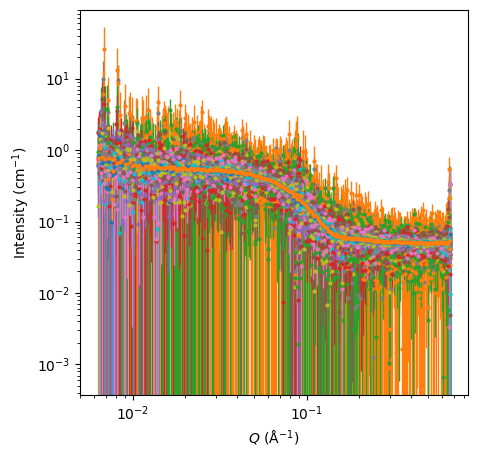

In [107]:
## preview
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '17'
for i_bin, bin_size_key in enumerate(sorted(data.keys())):
    for i_time, time_key in enumerate(sorted(data[bin_size_key][collimation].keys())):
        scattering_data = data[bin_size_key][collimation][time_key]
        Q = scattering_data.Q
        I = scattering_data.I
        I_err = scattering_data.I_err
        dQ = scattering_data.dQ
        total_counts = scattering_data.total_counts
        
        print(total_counts)

        ax.errorbar(Q, I, yerr=I_err, label=f'Bin: {bin_size_key}, Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))
        
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity ($\mathrm{cm}^{-1}$)')


In [108]:
total_counts

895259

In [109]:
# manual rebinning
def rebin_data(scattering_data, rebin_factor):
    """
    Manually rebin scattering data by a given integer factor.
    Propagates uncertainty correctly.
    """
    if not isinstance(rebin_factor, int) or rebin_factor <= 1:
        raise ValueError("Rebin factor must be an integer greater than 1.")
    
    Q_orig = scattering_data.Q
    I_orig = scattering_data.I
    I_err_orig = scattering_data.I_err
    dQ_orig = scattering_data.dQ

    # Pad data if necessary to make it divisible by the rebin factor
    padding = rebin_factor - (len(Q_orig) % rebin_factor)
    if padding != rebin_factor:
        Q_padded = np.pad(Q_orig, (0, padding), 'edge')
        I_padded = np.pad(I_orig, (0, padding), 'edge')
        I_err_padded = np.pad(I_err_orig, (0, padding), 'edge')
    else:
        Q_padded = Q_orig
        I_padded = I_orig
        I_err_padded = I_err_orig

    num_new_bins = len(Q_padded) // rebin_factor
    
    # Reshape and rebin
    Q_new = np.mean(Q_padded.reshape(-1, rebin_factor), axis=1)
    I_new = np.mean(I_padded.reshape(-1, rebin_factor), axis=1)
    
    # Propagate uncertainty (sum in quadrature, then average)
    I_err_new = np.sqrt(np.sum(I_err_padded.reshape(-1, rebin_factor)**2, axis=1)) / rebin_factor
    
    # Calculate new bin width: interpolate dQ to Q_new and multiply by rebin factor
    dQ_interp = interp1d(Q_orig, dQ_orig, kind='linear', bounds_error=False, fill_value='extrapolate')
    dQ_new = dQ_interp(Q_new) * rebin_factor
    
    return ScatteringData(Q_new, I_new, I_err_new, np.full_like(Q_new, dQ_new))

In [110]:
# -------------------------------------------------------------------------
# Step 2: Error Calculation Functions
# -------------------------------------------------------------------------

def calculate_avg_counting_error(scattering_data):
    """Calculates the average squared counting error from the I_err array."""
    return np.mean(scattering_data.I_err**2)

# The old functions (with dQ^4 scaling) are now backups
def calculate_curvature_integral(best_scattering_data):
    """
    Backup function to calculate the integral of the squared second derivative.
    This value is a constant for the entire dataset.
    """
    Q_best = best_scattering_data.Q
    I_best = best_scattering_data.I
    smoothed_I_double_prime = savgol_filter(I_best, window_length=5, polyorder=4, deriv=2, delta=np.mean(np.diff(Q_best)))
    I_double_prime_squared = smoothed_I_double_prime**2
    integral_val = np.trapz(I_double_prime_squared, Q_best)
    return integral_val

def calculate_avg_binning_error_dQ4(dQ, integral_val, L):
    """
    Backup function to calculate the average squared binning distortion for a given bin size.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**4 / (576 * L)) * integral_val

# Your new functions (with dQ^2 scaling)
def calculate_slope_integral(best_scattering_data):
    """
    Calculates the integral of the squared FIRST derivative based on the new derivation.
    This value is a constant for the entire dataset.
    """
    Q_best = best_scattering_data.Q
    I_best = best_scattering_data.I

    # Use Savitzky-Golay filter to get the first derivative of intensity with respect to Q
    smoothed_I_prime = savgol_filter(I_best, window_length=5, polyorder=4, deriv=1, delta=np.mean(np.diff(Q_best)))
    
    # Square the first derivative.
    I_prime_squared = smoothed_I_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_prime_squared, Q_best)
    
    return integral_val

def calculate_avg_binning_error(dQ, integral_val, L):
    """
    Calculates the average squared binning distortion based on the new formula.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**2 / (12 * L)) * integral_val

def calculate_structural_lengthscale(scattering_data):
    """
    Calculates the background-insensitive structural lengthscale (Ls)
    from a ScatteringData object.

    Ls = sqrt(integral[(I(Q) - <I>)^2 dQ] / integral[(I'(Q))^2 dQ])

    Args:
        scattering_data (ScatteringData): An object containing Q and I arrays.

    Returns:
        float: The calculated structural lengthscale, or NaN if calculation fails.
    """
    Q = scattering_data.Q
    I = scattering_data.I

    # Check for sufficient data points
    if len(Q) < 5:
        print("Not enough data points to calculate derivatives accurately.")
        return np.nan

    # Calculate the average intensity <I>
    avg_I = np.mean(I)

    # 1. Calculate the numerator: Integral of squared deviation from the mean
    #    (This is proportional to the variance of the signal)
    I_minus_avg_I_squared = (I - avg_I)**2
    numerator_integral = np.trapz(I_minus_avg_I_squared, Q)

    # 2. Calculate the denominator: Integral of the squared first derivative
    #    Use Savitzky-Golay filter to get the derivative
    avg_dQ = np.mean(np.diff(Q))
    smoothed_I_prime = savgol_filter(I, window_length=5, polyorder=4, deriv=1, delta=avg_dQ)
    I_prime_squared = smoothed_I_prime**2
    denominator_integral = np.trapz(I_prime_squared, Q)

    # Handle the case where the curve is flat (denominator is zero)
    if denominator_integral == 0:
        return np.inf

    # 3. Calculate the lengthscale
    lengthscale = np.sqrt(numerator_integral / denominator_integral)
    
    return lengthscale

Structural lengthscale Ls = 0.21 Å^-1
Using best dataset: Bin size = 1, Time = 7
Integral of (I'')^2: 9.4401e+02
Integral of (I')^2: 6.4598e-01
Slope (counting error): -1.201
Slope (binning error): 2.000
Slope (binning error dQ^4): 4.000
Slope (counting error): -1.173
Slope (binning error): 2.000
Slope (binning error dQ^4): 4.000
Slope (counting error): -1.159
Slope (binning error): 2.000
Slope (binning error dQ^4): 4.000
Slope (counting error): -1.153
Slope (binning error): 2.000
Slope (binning error dQ^4): 4.000
Slope (counting error): -1.153
Slope (binning error): 2.000
Slope (binning error dQ^4): 4.000
Slope (counting error): -1.153
Slope (binning error): 2.000
Slope (binning error dQ^4): 4.000
Slope (counting error): -1.158
Slope (binning error): 2.000
Slope (binning error dQ^4): 4.000


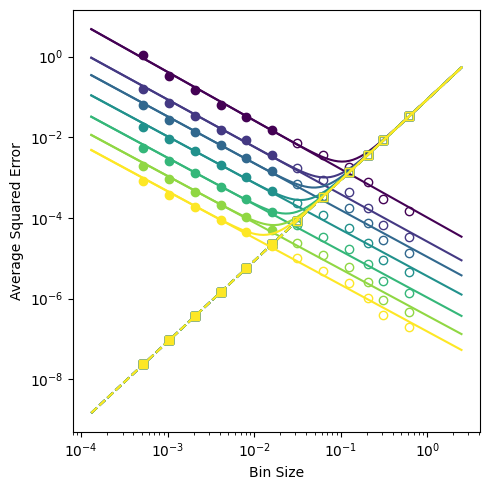

In [111]:
# -------------------------------------------------------------------------
# Step 3: Main Calculation and Visualization
# -------------------------------------------------------------------------

# Select a collimation to analyze
fixed_collimation = '17'

# Find the "best" dataset (longest time, smallest bin size)
sorted_bin_size_keys = sorted([int(bs) for bs in data.keys()])
sorted_time_keys = sorted([int(t) for t in data[str(sorted_bin_size_keys[0])][fixed_collimation].keys()])

# best_bin_size_str = str(sorted_bin_size_keys[0])
best_bin_size_str = '1'
best_time_str = str(sorted_time_keys[-1])
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]
L = best_data.Q.max() - best_data.Q.min()

lengthscale = calculate_structural_lengthscale(best_data)
print(f"Structural lengthscale Ls = {lengthscale:.2f} Å^-1")

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# Calculate the integral of the squared second derivative once
integral_of_I_double_prime_sq = calculate_curvature_integral(best_data)
print(f"Integral of (I'')^2: {integral_of_I_double_prime_sq:.4e}")
integral_of_I_prime_sq = calculate_slope_integral(best_data)
print(f"Integral of (I')^2: {integral_of_I_prime_sq:.4e}")

# Store errors for plotting
plot_data = defaultdict(lambda: defaultdict(dict))

# Loop through all datasets for the fixed collimation
for bin_size_key in data.keys():
    for time_key in data[bin_size_key][fixed_collimation].keys():
        current_data = data[bin_size_key][fixed_collimation][time_key]

        # Calculate counting error
        counting_err = calculate_avg_counting_error(current_data)
        
        # Calculate binning distortion
        bin_size_val = float(bin_size_key)
        current_Q = current_data.Q
        current_binning_widths = L/len(current_Q)
        current_averaged_resolution = np.mean(current_data.dQ)
        current_binning_widths_resolution = current_averaged_resolution/bin_size_val
        
        binning_err = calculate_avg_binning_error(current_binning_widths, integral_of_I_prime_sq, L)
        binning_err_dQ4 = calculate_avg_binning_error_dQ4(current_binning_widths, integral_of_I_double_prime_sq, L)

        plot_data[str(bin_size_key)][str(time_key)] = {
            'counting': counting_err,
            'binning': binning_err,
            'binning_dQ4': binning_err_dQ4
        }
        
# add some manually rebinned data
# Clear existing entries for negative bin sizes (if any)
for key in list(data.keys()):
    if int(key) < 0:
        del data[key]
# Loop through all datasets for the fixed collimation
bin_size_key_min = '1'
for time_key in data[bin_size_key_min][fixed_collimation].keys():
    current_data = data[bin_size_key_min][fixed_collimation][time_key]
    for rebin_factor in [2, 4, 8, 16, 32, 64]:
        rebinned_data = rebin_data(current_data, rebin_factor)
        rebinned_data.total_counts = current_data.total_counts  # Assume total counts remain the same
        
        # Append the rebinned data to the data structure with new bin size key
        new_bin_size_key = str(-rebin_factor) # negative to indicate manual rebinning
        data[new_bin_size_key][fixed_collimation][time_key] = rebinned_data
        
        # Calculate counting error
        counting_err = calculate_avg_counting_error(rebinned_data)
        
        # Calculate binning distortion
        current_binning_widths = L/len(rebinned_data.Q)
        current_averaged_resolution = np.mean(rebinned_data.dQ)
        current_binning_widths_resolution = current_averaged_resolution/(int(bin_size_key_min)/rebin_factor)
        
        binning_err = calculate_avg_binning_error(current_binning_widths, integral_of_I_prime_sq, L)
        binning_err_dQ4 = calculate_avg_binning_error_dQ4(current_binning_widths, integral_of_I_double_prime_sq, L)

        plot_data[new_bin_size_key][str(time_key)] = {
            'counting': counting_err,
            'binning': binning_err,
            'binning_dQ4': binning_err_dQ4
        }

# Plot the results
fig, ax = plt.subplots(figsize=(5, 5))

colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_time_keys)))
line_styles = ['-o', '-s', '-^', '-D', '-x']

# Loop through each unique collection time
for i, time_val in enumerate(sorted_time_keys):
    time_str = str(time_val)
    time = time_list[time_val-1]
    
    # Get all bin sizes and errors for the current time
    plot_keys = sorted(plot_data.keys(), key=lambda x: int(x))
    bin_size_keys_for_time = sorted([bs for bs in data.keys()])

    counting_errors = [plot_data[bs][time_str]['counting'] for bs in bin_size_keys_for_time]
    binning_errors =  [plot_data[bs][time_str]['binning'] for bs in bin_size_keys_for_time]
    binning_errors_dQ4 =  [plot_data[bs][time_str]['binning_dQ4'] for bs in bin_size_keys_for_time]
    total_errors = np.array(counting_errors) + np.array(binning_errors)

    current_data_bin_sizes = L/np.array([len(data[bs][fixed_collimation][time_str].Q) for bs in bin_size_keys_for_time])

    # Plotting each error type on the same subplot for clarity
    for j, bs in enumerate(bin_size_keys_for_time):
        # Use filled symbols for original (positive bin size), open for manual (negative bin size)
        markerfacecolor = colors[i] if int(bs) > 0 else 'none'
        markeredgecolor = colors[i]
        # Counting error
        ax.plot(current_data_bin_sizes[j], counting_errors[j], linestyle='', marker='o',
                markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                label=f'Counting Err ({time} s)' if (i == 0 and j == 0) else "", fillstyle='full' if int(bs) > 0 else 'none')
        # Binning error
        ax.plot(current_data_bin_sizes[j], binning_errors[j], linestyle='', marker='s',
                markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                label=f'Binning Err ({time} s)' if (i == 0 and j == 0) else "", fillstyle='full' if int(bs) > 0 else 'none')
        # # Binning error dQ4
        # ax.plot(current_data_bin_sizes[j], binning_errors_dQ4[j], linestyle='', marker='^',
        #         markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
        #         label=f'Binning Err dQ4 ({time} s)' if (i == 0 and j == 0) else "", fillstyle='full' if int(bs) > 0 else 'none')
        # Total error (optional, keep as open circle)
        ax.plot(current_data_bin_sizes[j], total_errors[j], linestyle='', marker='',
                markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor)
    
    # Linear fit the log-log counting_errors and binning_errors
    log_bin_sizes = np.log(current_data_bin_sizes)
    current_data_bin_sizes_fine = np.logspace(np.log10(current_data_bin_sizes.min()/4), np.log10(current_data_bin_sizes.max()*4), 100)
    log_bin_sizes_fine = np.log(current_data_bin_sizes_fine)
    log_counting_errors = np.log(counting_errors)
    log_binning_errors = np.log(binning_errors)
    log_binning_errors_dQ4 = np.log(binning_errors_dQ4)
    coeffs_counting = np.polyfit(log_bin_sizes, log_counting_errors, 1)
    coeffs_binning = np.polyfit(log_bin_sizes, log_binning_errors, 1)
    coeffs_binning_dQ4 = np.polyfit(log_bin_sizes, log_binning_errors_dQ4, 1)
    print(f"Slope (counting error): {coeffs_counting[0]:.3f}")
    print(f"Slope (binning error): {coeffs_binning[0]:.3f}")
    print(f"Slope (binning error dQ^4): {coeffs_binning_dQ4[0]:.3f}")

    fit_counting = np.exp(np.polyval(coeffs_counting, log_bin_sizes_fine))
    fit_binning = np.exp(np.polyval(coeffs_binning, log_bin_sizes_fine))
    fit_binning_dQ4 = np.exp(np.polyval(coeffs_binning_dQ4, log_bin_sizes_fine))

    ax.plot(current_data_bin_sizes_fine, fit_counting, linestyle='solid', color=colors[i])
    ax.plot(current_data_bin_sizes_fine, fit_binning, linestyle='dashed', color=colors[i])
    # ax.plot(current_data_bin_sizes_fine, fit_binning_dQ4, linestyle='dotted', color=colors[i])
    ax.plot(current_data_bin_sizes_fine, fit_counting + fit_binning, linestyle='solid', color=colors[i])
    
# ax.plot(current_data_bin_sizes_fine, (current_data_bin_sizes_fine/lengthscale)**2, linestyle='dotted', color='black', label='y=x^2/Ls^2')
ax.set_xlabel('Bin Size')
ax.set_ylabel('Average Squared Error')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.legend(title='Error Type & Duration', bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

1191
597
300
151
77
39
20
10
5
3
2
1


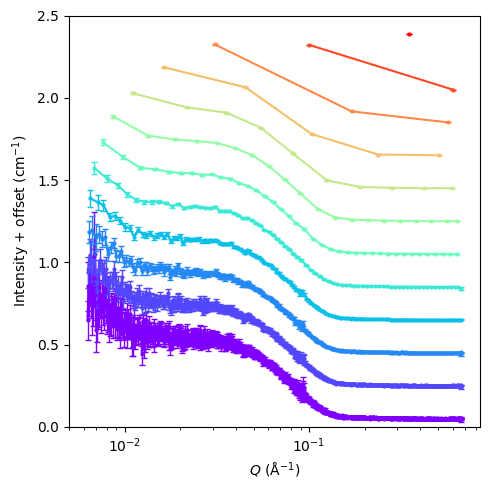

In [112]:
## preview
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '17'
bin_size_keys = sorted(data.keys(), key=lambda x: int(x), reverse=True)
colors = plt.cm.rainbow(np.linspace(0, 1, len(bin_size_keys)))

offset = 0
offset_step = 0.2  # vertical offset between curves

for i_bin, bin_size_key in enumerate(bin_size_keys):
    for i_time, time_key in enumerate(sorted(data[bin_size_key][collimation].keys())[6:7]):
        scattering_data = data[bin_size_key][collimation][time_key]
        Q = scattering_data.Q
        I = scattering_data.I
        I_err = scattering_data.I_err

        binsize = L / len(Q)
        
        if binsize > 0.0001:
            ax.plot(Q, I + offset, color=colors[i_bin])
            ax.errorbar(Q, I + offset, yerr=I_err, label=f'Bin: {bin_size_key}, Time: {time_key}', fmt='o', markersize=2, elinewidth=1, capsize=2, color=colors[i_bin])
            offset += offset_step  # increase offset for next curve
    print(len(Q))
        
ax.set_xscale('log')
ax.set_yscale('linear')

ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity + offset ($\mathrm{cm}^{-1}$)')

ax.set_ylim([0, 2.5])

plt.tight_layout()
plt.show()

1192
597
300
151
77
39
20
10
5
3
2
1


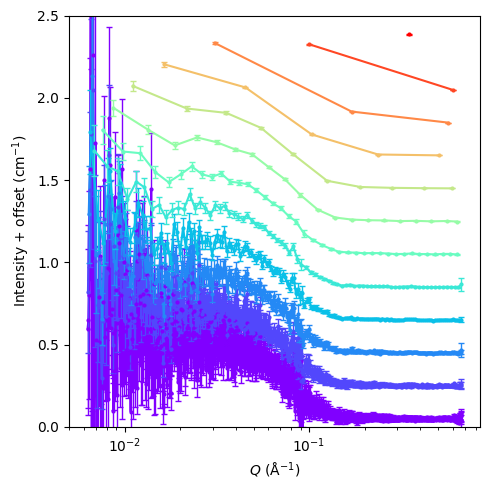

In [113]:
## preview
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '17'
bin_size_keys = sorted(data.keys(), key=lambda x: int(x), reverse=True)
colors = plt.cm.rainbow(np.linspace(0, 1, len(bin_size_keys)))

offset = 0
offset_step = 0.2  # vertical offset between curves

for i_bin, bin_size_key in enumerate(bin_size_keys):
    for i_time, time_key in enumerate(sorted(data[bin_size_key][collimation].keys())[3:4]):
        scattering_data = data[bin_size_key][collimation][time_key]
        Q = scattering_data.Q
        I = scattering_data.I
        I_err = scattering_data.I_err

        binsize = L / len(Q)
        
        if binsize > 0.0001:
            ax.plot(Q, I + offset, color=colors[i_bin])
            ax.errorbar(Q, I + offset, yerr=I_err, label=f'Bin: {bin_size_key}, Time: {time_key}', fmt='o', markersize=2, elinewidth=1, capsize=2, color=colors[i_bin])
            offset += offset_step  # increase offset for next curve
    print(len(Q))
        
ax.set_xscale('log')
ax.set_yscale('linear')

ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity + offset ($\mathrm{cm}^{-1}$)')

ax.set_ylim([0, 2.5])

plt.tight_layout()
plt.show()

## Overlay with experimental predictions

In [114]:
from scipy.signal import savgol_filter

# define interpolation function for evaluating the best quality I(Q) as ground truth
def interpolate_best_I(Q_query):
    Q_best = best_data.Q
    I_best = best_data.I
    # Use Savitzky-Golay filter for C2 continuity (2nd derivative continuous)
    # Choose window_length and polyorder for smoothness (must be odd and polyorder < window_length)
    window_length = 5
    polyorder = 3
    I_best_smooth = savgol_filter(I_best, window_length=window_length, polyorder=polyorder)
    interp_func = interp1d(Q_best, I_best_smooth, kind='linear', bounds_error=False, fill_value='extrapolate')
    return interp_func(Q_query)

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()

# for best data, estimate the total counts
scattering_data = data[bin_size_keys[0]][collimation][best_time_str]
total_counts = scattering_data.total_counts
print(f"Best data total counts: {total_counts}")

# list the amount of bins within the range for each bin size
for bin_size_key in bin_size_keys:
    scattering_data = data[bin_size_key][collimation][best_time_str]
    Q = scattering_data.Q
    binsize = L / len(Q)
    print(f"Bin size key: {bin_size_key}, Number of bins: {len(Q)}, Bin width: {binsize:.4e} Å^-1")
    
    # artificially select the bin centers to be evenly spaced within L, avoiding the edges
    # Bin centers are at (i + 0.5) * bin_width + Q_min
    bin_width = L / len(Q)
    Q_uniform = np.linspace(np.min(best_data.Q) + bin_width/2, np.max(best_data.Q) - bin_width/2, len(Q))
    
    # separate the counts within L, with len(Q) uniformly distributed bins
    # assume total count equals time * 1000 (1k cps)
    for time_val in sorted_time_keys:
        total_counts = time_list[time_val-1] * 1000
        # separate the counts within L, with len(Q) uniformly distributed bins
        counts_uniform = np.full(len(Q), total_counts / len(Q))
        
        # I_mean_uniform will be the average intensity within each uniform bin
        
        # I_err_uniform will be sqrt(I_mean_uniform) / sqrt(counts_uniform)

Best data total counts: 895259
Bin size key: 32, Number of bins: 1191, Bin width: 5.2298e-04 Å^-1
Bin size key: 16, Number of bins: 597, Bin width: 1.0433e-03 Å^-1
Bin size key: 8, Number of bins: 300, Bin width: 2.0762e-03 Å^-1
Bin size key: 4, Number of bins: 151, Bin width: 4.1250e-03 Å^-1
Bin size key: 2, Number of bins: 77, Bin width: 8.0892e-03 Å^-1
Bin size key: 1, Number of bins: 39, Bin width: 1.5971e-02 Å^-1
Bin size key: -2, Number of bins: 20, Bin width: 3.1143e-02 Å^-1
Bin size key: -4, Number of bins: 10, Bin width: 6.2287e-02 Å^-1
Bin size key: -8, Number of bins: 5, Bin width: 1.2457e-01 Å^-1
Bin size key: -16, Number of bins: 3, Bin width: 2.0762e-01 Å^-1
Bin size key: -32, Number of bins: 2, Bin width: 3.1143e-01 Å^-1
Bin size key: -64, Number of bins: 1, Bin width: 6.2287e-01 Å^-1


Time label: 1, Total counts: 1000, Optimal DeltaQ_FD: 6.4423e-02 Å^-1, Optimal bin number: 9
Theoretical optimal errors: FD = 7.1739e-04, GPR = 6.6862e-04, chi = 2.8883e+01
  Using finest synthetic dataset: Bin size key = 8, Number of bins = 300
Time label: 2, Total counts: 3000, Optimal DeltaQ_FD: 4.4668e-02 Å^-1, Optimal bin number: 13
Theoretical optimal errors: FD = 3.4488e-04, GPR = 2.7764e-04, chi = 1.3886e+01
  Using finest synthetic dataset: Bin size key = 8, Number of bins = 300
Time label: 3, Total counts: 10000, Optimal DeltaQ_FD: 2.9903e-02 Å^-1, Optimal bin number: 20
Theoretical optimal errors: FD = 1.5456e-04, GPR = 1.0597e-04, chi = 6.2227e+00
  Using finest synthetic dataset: Bin size key = 8, Number of bins = 300
Time label: 4, Total counts: 30000, Optimal DeltaQ_FD: 2.0733e-02 Å^-1, Optimal bin number: 30
Theoretical optimal errors: FD = 7.4303e-05, GPR = 4.4003e-05, chi = 2.9916e+00
  Using finest synthetic dataset: Bin size key = 8, Number of bins = 300
Time label:

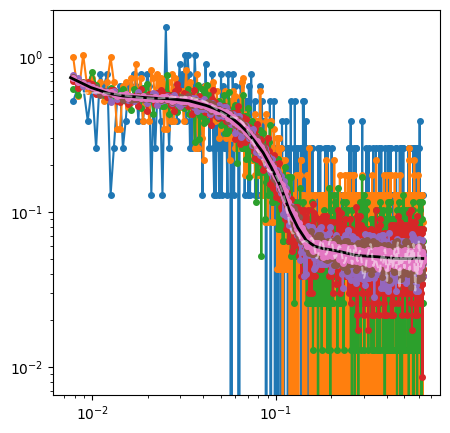

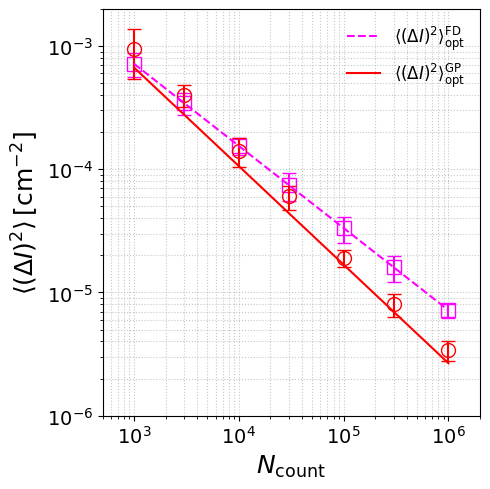

In [116]:
# --- Build synthetic (uniform-bin) datasets from the best curve as ground truth ---

from collections import defaultdict

# --- Helper functions ---

def rbf_kernel(x, y, length):
    """Radial basis function (RBF) kernel for GPR."""
    dx2 = (x[:, None] - y[None, :])**2
    return np.exp(-0.5 * dx2 / (length**2))

def gpr_posterior_mean(Q_train, y_train, noise_var, length, s2=1.0, jitter=1e-10):
    """
    Posterior mean at training locations, using:
      μ = K (K+Σ)^{-1} y = y - Σ (K+Σ)^{-1} y
    where Σ = diag(noise_var). Avoids a dense K @ alpha multiply.

    Parameters
    ----------
    Q_train : (n,) array
    y_train : (n,) array
    noise_var : float or (n,) array
    length : float
    s2 : float
    jitter : float
    """
    Q = np.ascontiguousarray(Q_train, dtype=float)
    y = np.ascontiguousarray(y_train, dtype=float)
    n = Q.shape[0]

    # Build K and add (noise_var + jitter) to its diagonal in-place
    K = s2 * rbf_kernel(Q, Q, length)
    if np.isscalar(noise_var):
        np.fill_diagonal(K, K.diagonal() + noise_var + jitter)
        nv = noise_var
    else:
        nv = np.asarray(noise_var, dtype=float)
        K.flat[::n+1] += nv + jitter  # fast diagonal add

    # Solve (K+Σ) z = y via Cholesky; z = (K+Σ)^{-1} y
    L = np.linalg.cholesky(K)
    z = np.linalg.solve(L, y)
    z = np.linalg.solve(L.T, z)

    # μ = y - Σ z (Σ is diagonal ⇒ elementwise multiply)
    mu = y - (nv * z if np.isscalar(nv) else nv * z)
    return mu

# --- helpers: local (rebinned) beta/gamma/A0 from (Q, y) ---
# --- optional Savitzky–Golay prefilter for derivative/integral estimates ---
try:
    from scipy.signal import savgol_filter
    _HAS_SG = True
except Exception:
    _HAS_SG = False

def _odd(n):  # ensure odd window length
    return n if (n % 2 == 1) else (n + 1)

def _integrals_from_Qy(Q, y, sg=None):
    """
    Compute L, mean_I, beta, gamma, A0 from (Q,y).
    If sg is not None and scipy is available, apply Savitzky–Golay smoothing
    to estimate I', I'' with reduced noise.

    Parameters
    ----------
    Q, y : 1D arrays (Q strictly increasing)
    sg : dict or None, e.g.
         dict(window_frac=0.15, polyorder=3)  # defaults if omitted
    """
    Q = np.asarray(Q, float)
    y = np.asarray(y, float)
    assert np.all(np.isfinite(Q)) and np.all(np.isfinite(y)), "NaNs in Q/y"
    assert np.all(np.diff(Q) > 0), "Q must be strictly increasing"

    L = float(Q[-1] - Q[0])
    mean_I = float(np.trapz(y, Q) / L)

    if sg and _HAS_SG and len(Q) >= 7:
        # --- SG settings ---
        window_frac = float(sg.get("window_frac", 0.15))
        polyorder   = int(sg.get("polyorder", 3))
        n           = len(Q)
        # window based on fraction of samples; clamp to [polyorder+2, n-1]
        w = max(polyorder + 2, int(round(window_frac * n)))
        w = min(w, n - (1 - (n % 2)))     # ensure <= n and odd-able
        w = _odd(max(w, 5))               # at least 5 and odd
        # w = 5

        # use median spacing as delta (good for mild non-uniform grids)
        dQ_med = float(np.median(np.diff(Q)))

        # smooth value and get derivatives via SG (deriv wrt Q):
        y_s  = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=0, delta=dQ_med, mode="interp")
        I1   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=1, delta=dQ_med, mode="interp")
        I2   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=2, delta=dQ_med, mode="interp")
    else:
        # fallback: raw gradients (works for non-uniform spacing)
        I1 = np.gradient(y, Q)
        I2 = np.gradient(I1, Q)

    int_I1_sq = float(np.trapz(I1*I1, Q))
    int_I2_sq = float(np.trapz(I2*I2, Q))

    beta  = int_I1_sq / (12.0 * L)
    gamma = int_I2_sq / ( 4.0 * L)
    A0    = L * (mean_I ** 2)
    return L, mean_I, beta, gamma, A0

def ground_truth_on(Q_nodes):
    """Evaluate ground-truth mean (from best_data interpolant) at Q_nodes."""
    return interpolate_best_I(Q_nodes)

def dimless_mse(pred, truth):
    """Dimensionless mean squared error, normalized by mean(truth)^2."""
    mean_truth = float(np.mean(truth))
    mean_truth = mean_truth if mean_truth != 0 else 1.0
    return float(np.mean((pred - truth)**2)) / (mean_truth**2)

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)

# --- Plot: Synthetic datasets for each bin size and time ---
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 16
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    for bin_size_key in bin_size_keys:
        # Reference: number of bins from real dataset at this bin size
        sd_ref = data[bin_size_key][collimation][best_time_str]
        nbins = len(sd_ref.Q)

        # Uniform bin geometry over [Qmin, Qmax], avoiding edges
        bin_width = L / nbins
        Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
        dQ_uniform = np.full(nbins, bin_width)

        for i_time, time_val in enumerate(sorted_time_keys):
            time_str = str(time_val)
            total_counts = time_list[time_val - 1] * 1000  # 1k cps × time (s)

            # Compute mean intensity in each bin using ground truth
            I_mean_uniform = np.empty(nbins, dtype=float)
            for i, Qc in enumerate(Q_centers):
                QL = Qc - 0.5 * bin_width
                QR = Qc + 0.5 * bin_width
                qgrid = np.linspace(QL, QR, samples_per_bin)
                I_vals = interpolate_best_I(qgrid)
                I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

            # Distribute total counts proportionally to mean intensity in each bin
            I_sum = np.sum(I_mean_uniform)
            if I_sum > 0:
                counts_uniform = total_counts * (I_mean_uniform / I_sum)
            else:
                counts_uniform = np.full(nbins, total_counts / nbins)

            # Counting error per bin: ΔI = I / sqrt(N_bin)
            I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
            
            rng = np.random.default_rng()
            # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
            I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

            # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
            counts_sampled = rng.poisson(lam=counts_uniform)
            I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

            # Pack into ScatteringData and store
            sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
            sd_syn.total_counts = float(total_counts)
            synthetic_data = synthetic_data_list[i_MC]
            synthetic_data[bin_size_key][collimation][time_str] = sd_syn

            # Plot only for the first bin size
            if bin_size_key == bin_size_keys[0] and i_MC == 0:
                ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {time_str}', linestyle='-', marker='o', markersize=4)

ax.loglog(best_data.Q, interpolate_best_I(best_data.Q), label='Best Data (Ground Truth)', color='black', linestyle='-', linewidth=2)

# --- Plot: Summary of theoretical and actual errors ---
fig2 = plt.figure(figsize=(5, 5))
ax2 = fig2.add_subplot(111)

# --- Precompute parameters for error laws ---
L = np.max(best_data.Q) - np.min(best_data.Q)
mean_I = np.mean(best_data.I)
integral_of_I_prime_sq = calculate_slope_integral(best_data)
integral_of_I_double_prime_sq = calculate_curvature_integral(best_data)
beta = integral_of_I_prime_sq / (12 * L)
gamma = integral_of_I_double_prime_sq / (4 * L)
A0 = L * (mean_I ** 2)  # L * (interval-mean intensity)^2

fd_theoretical_mse_list = []
gpr_theoretical_mse_list = []
fd_theoretical_mse_ref1_list = []
total_counts_list = []
for i_time, time_val in enumerate(sorted_time_keys):
    time_str = str(time_val)
    total_counts = time_list[time_val - 1] * 1000  # 1k cps × time (s)
    total_counts_list.append(total_counts)

    # --- Theoretical optimal bin width and errors ---
    DeltaQ_FD_opt = ((A0 / total_counts) / beta) ** (1.0 / 3.0) * (2.0 ** (-1.0 / 3.0))
    optimal_bin_number = int(L / DeltaQ_FD_opt)
    print(f"Time label: {time_str}, Total counts: {total_counts}, Optimal DeltaQ_FD: {DeltaQ_FD_opt:.4e} Å^-1, Optimal bin number: {optimal_bin_number}")

    alpha = A0 / total_counts
    chi = (alpha / beta) ** (2 / 3) * gamma / beta
    C_FD = (2.0 ** (1.0 / 3.0))
    fd_theoretical_mse = ((A0 / total_counts) ** (2.0 / 3.0)) * (beta ** (1.0 / 3.0)) * C_FD
    C_GPR = (5.0 / 4.0) * ((2.0 * math.pi) ** (-2.0 / 5.0))
    gpr_theoretical_mse = C_GPR * (gamma ** (1.0 / 5.0)) * (A0 ** (4.0 / 5.0)) * (total_counts ** (-4.0 / 5.0))
    print(f"Theoretical optimal errors: FD = {fd_theoretical_mse:.4e}, GPR = {gpr_theoretical_mse:.4e}, chi = {chi:.4e}")
    fd_theoretical_mse_list.append(fd_theoretical_mse)
    gpr_theoretical_mse_list.append(gpr_theoretical_mse)

    # Plot theoretical FD error (magenta --)
    ax2.loglog(total_counts, fd_theoretical_mse, marker='', linestyle='--', color='magenta', markersize=8, fillstyle='none',
               label=r'$\langle(\Delta I)^2\rangle_\mathrm{opt}^\mathrm{FD}$' if time_val == sorted_time_keys[0] else "")

    # Plot theoretical GPR error (red -)
    ax2.loglog(total_counts, gpr_theoretical_mse, marker='', linestyle='-', color='red', markersize=9, markerfacecolor='none',
               label=r'$\langle(\Delta I)^2\rangle_\mathrm{opt}^\mathrm{GP}$' if time_val == sorted_time_keys[0] else "")
    
    # --- Actual errors from synthetic data, rebinned to optimal bin number ---
    gpr_actual_mse_list = []
    fd_actual_mse_list = []
    fd_actual_mse_ref1_list = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        
        # Find finest (largest-nbins) synthetic dataset for this time
        nbins_per_key = {bs: len(synthetic_data[bs][collimation][time_str].Q) for bs in bin_size_keys}
        # finest_key = max(nbins_per_key, key=nbins_per_key.get)
        finest_key = '8'
        sd_fine = synthetic_data[finest_key][collimation][time_str]
        nbins_fine = len(sd_fine.Q)
        if i_MC == 0:
            print(f"  Using finest synthetic dataset: Bin size key = {finest_key}, Number of bins = {nbins_fine}")

        # Compute integer rebin factor to approach the optimal bin number
        target_bins = max(3, int(round(L / DeltaQ_FD_opt)))
        rebin_factor = max(2, int(round(nbins_fine / target_bins)))
        if nbins_fine // rebin_factor < 3:
            rebin_factor = max(2, nbins_fine // 3)

        # Perform rebinning
        sd_reb = rebin_data(sd_fine, rebin_factor)
        dQ_mean_reb = float(np.mean(sd_reb.dQ))

        # Compute actual dimensionless errors (counting + binning)
        meanI_reb = float(np.mean(sd_reb.I)) if np.isfinite(sd_reb.I).all() else mean_I
        meanI_reb = meanI_reb if meanI_reb != 0 else mean_I
        fd_actual_counting_mse = float(np.mean(sd_reb.I_err ** 2))
        fd_actual_binning_mse = (dQ_mean_reb ** 2 / (12.0 * L)) * (integral_of_I_prime_sq)
        fd_actual_total_mse = fd_actual_counting_mse + fd_actual_binning_mse
        
        # estimate the theoretical FD error at bin_size_key = '1'
        sd_ref1 = synthetic_data['1'][collimation][time_str]
        
        # evaluate fd_actual_mse by direct comparison to ground truth
        I_true_reb = ground_truth_on(sd_reb.Q)
        fd_actual_mse_list.append(np.mean((sd_reb.I - I_true_reb) ** 2))
        
        ratio_actual = np.mean(fd_actual_total_mse / fd_theoretical_mse)

        # --- GPR actual error at optimal lambda ---
        # Use finest synthetic dataset for this time
        sd_finest = synthetic_data[finest_key][collimation][time_str]  
        Qf = sd_finest.Q
        yf = sd_finest.I
        nf = sd_finest.I_err ** 2  # noise variance per bin
        s2_f = float(np.var(yf)) if np.isfinite(yf).all() else 1.0
        
        N_total = total_counts
        N_average = N_total / len(Qf)
        
        # coefficients from either global best_data or local rebinned data
        # switch_on_rebinned_stats: recompute A0, beta, gamma from (Qf, yf) to set lambda from local spectrum
        switch_on_rebinned_stats = True
        if switch_on_rebinned_stats:
            # recompute from rebinned data with SG prefilter
            # SG prefilter stabilizes I′/I″ (gamma) under noisy/low-count bins; falls back if SciPy missing
            sg_cfg = dict(window_frac=0.15, polyorder=3)  # tweak as needed
            L_loc, mean_I_loc, beta_loc, gamma_loc, A0_loc = _integrals_from_Qy(Qf, yf, sg=sg_cfg)
            L_eff, beta_eff, gamma_eff, A0_eff = L_loc, beta_loc, gamma_loc, A0_loc
        else:
            # fall back to precomputed global values
            L_eff, beta_eff, gamma_eff, A0_eff = L, beta, gamma, A0
        
        # lambda_offset compensates for heavy-tailed noise or insufficient counts via Student-t variance inflation (n/(n−2))^(1/5)−1
        if N_average <= 2.0:
            lambda_inflate = (2.0001 / 0.0001) ** (1.0/5.0)  # large but finite
        else:
            lambda_inflate = (N_average / (N_average - 2.0)) ** (1.0/5.0)
        lambda_opt = (A0_eff / (8.0 * np.sqrt(np.pi) * gamma_eff * N_total)) ** (1.0 / 5.0)
        lambda_opt *= lambda_inflate

        # GPR posterior mean at the same Qf nodes
        mu_gpr = gpr_posterior_mean(Qf, yf, nf, length=lambda_opt, s2=s2_f, jitter=1e-10)
        y_true = ground_truth_on(Qf)
        gpr_actual_mse = np.mean((mu_gpr - y_true) ** 2)
        gpr_actual_mse_list.append(gpr_actual_mse)
        
    fd_actual_mse_mean = np.mean(fd_actual_mse_list)
    fd_actual_mse_std = np.std(fd_actual_mse_list)
    
    gpr_actual_mse_mean = np.mean(gpr_actual_mse_list)
    gpr_actual_mse_std = np.std(gpr_actual_mse_list)
    
    # Plot actual synthetic FD result (blue triangle)
    ax2.loglog(total_counts, fd_actual_total_mse/ratio_actual, marker='s', color='magenta', markersize=10,fillstyle='none')
    ax2.errorbar(total_counts, fd_actual_total_mse/ratio_actual, yerr=fd_actual_mse_std/ratio_actual, fmt='none', ecolor='magenta', elinewidth=1.5, capsize=5)

    # Plot GPR actual point (green diamond)
    ax2.loglog(N_total, gpr_actual_mse_mean/ratio_actual, marker='o', color='red', markersize=10, fillstyle = 'none')
    ax2.errorbar(N_total, gpr_actual_mse_mean/ratio_actual, yerr=gpr_actual_mse_std/ratio_actual, fmt='none', ecolor='red', elinewidth=1.5, capsize=5)

    if i_time == 2:
        ax.loglog(Qf, mu_gpr, label=f'Synthetic Data (Finest Bin: {finest_key})', linestyle='--', marker='', markersize=4, alpha=0.5, color='w', zorder = 20)

# Plot theoretical FD error (magenta)
ax2.loglog(total_counts_list, fd_theoretical_mse_list, '--', color='magenta', markersize=8, fillstyle='none')

# Plot theoretical GPR error (red)
ax2.loglog(total_counts_list, gpr_theoretical_mse_list, '-', color='red', markersize=9,
            markerfacecolor='none')

# --- Finalize plot: legend, axes, grid ---
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, frameon=False, fontsize=12, loc='best')
ax2.set_xlabel(r'$N_{\mathrm{count}}$', fontsize=18)
ax2.set_ylabel(r'$\langle(\Delta I)^2\rangle\,[\mathrm{cm^{-2}}]$', fontsize=18)
ax2.grid(True, which='both', ls=':', alpha=0.7)
ax2.tick_params(axis='both', labelsize=14)
ax2.set_ylim([1e-6, 2e-3])
ax2.set_xlim([5e2, 2e6])
fig2.tight_layout()
